<a href="https://colab.research.google.com/github/sacck21/prediccion-de-propiedades-moleculares/blob/main/03-Modelo-e-iteraciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()
init.endpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U -q kaggle

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files

In [ ]:
files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vanessapabon","key":"7367786aa2c8be8d2185064d97632e38"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c champs-scalar-coupling

 97% 367M/377M [00:04<00:00, 101MB/s] 
100% 377M/377M [00:04<00:00, 96.1MB/s]


In [ ]:
!unzip -o '/content/champs-scalar-coupling.zip'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: structures/dsgdb9nsd_128302.xyz  
  inflating: structures/dsgdb9nsd_128303.xyz  
  inflating: structures/dsgdb9nsd_128304.xyz  
  inflating: structures/dsgdb9nsd_128305.xyz  
  inflating: structures/dsgdb9nsd_128306.xyz  
  inflating: structures/dsgdb9nsd_128308.xyz  
  inflating: structures/dsgdb9nsd_128309.xyz  
  inflating: structures/dsgdb9nsd_128310.xyz  
  inflating: structures/dsgdb9nsd_128311.xyz  
  inflating: structures/dsgdb9nsd_128312.xyz  
  inflating: structures/dsgdb9nsd_128313.xyz  
  inflating: structures/dsgdb9nsd_128314.xyz  
  inflating: structures/dsgdb9nsd_128315.xyz  
  inflating: structures/dsgdb9nsd_128316.xyz  
  inflating: structures/dsgdb9nsd_128317.xyz  
  inflating: structures/dsgdb9nsd_128318.xyz  
  inflating: structures/dsgdb9nsd_128319.xyz  
  inflating: structures/dsgdb9nsd_128320.xyz  
  inflating: structures/dsgdb9nsd_128321.xyz  
  inflating: structures/dsgdb9nsd_128322.xyz  

In [ ]:
import pandas as pd
import random
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import local.lib.timeseries as ts
from local.lib import calhousing as ch
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from scipy import stats
from scipy import optimize
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from local.lib import mlutils



# Se cargar los datasets de entrenamiento (train) y testeo (test)


In [ ]:
df_train=pd.read_csv('train.csv')
df_train[:20]

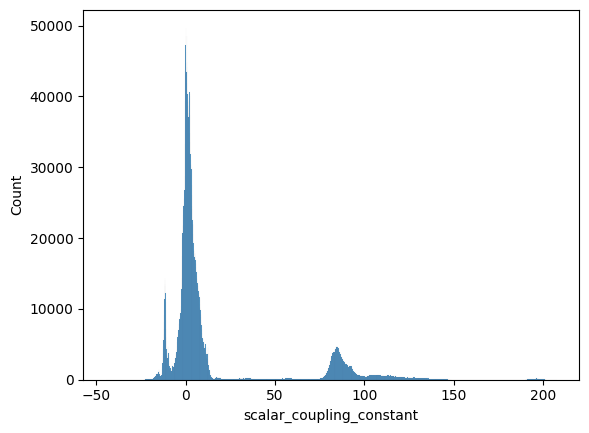

In [ ]:
sns.histplot(df_train['scalar_coupling_constant']);

In [ ]:
df_test=pd.read_csv('/content/test.csv')
df_test

#Datos adicionales:

Se cargan o extraen el resto de datasets, para que sean unidos al dataframe principal

In [ ]:
# Estructura
df_struct=pd.read_csv('/content/structures.csv')
df_struct

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397
...,...,...,...,...,...,...
2358870,dsgdb9nsd_133885,11,H,-1.454004,-0.967309,1.459246
2358871,dsgdb9nsd_133885,12,H,0.277779,-2.697872,0.195770
2358872,dsgdb9nsd_133885,13,H,2.515854,-1.151784,0.527369
2358873,dsgdb9nsd_133885,14,H,0.013699,1.199431,-1.680192


In [ ]:
# Momento dipolar
dipole = pd.read_csv('dipole_moments.csv')
dipole

,molecule_name,X,Y,Z
0,dsgdb9nsd_000001,0.0000,0.0000,0.0000
1,dsgdb9nsd_000002,-0.0002,0.0000,1.6256
2,dsgdb9nsd_000003,0.0000,0.0000,-1.8511
3,dsgdb9nsd_000004,0.0000,0.0000,0.0000
4,dsgdb9nsd_000005,0.0000,0.0000,-2.8937
...,...,...,...,...
130784,dsgdb9nsd_133881,1.2590,0.1153,-1.0814
130785,dsgdb9nsd_133882,-0.3710,-1.2435,0.0000
130786,dsgdb9nsd_133883,-0.4359,1.1694,-0.0000
130787,dsgdb9nsd_133884,1.3623,1.4058,-0.0000


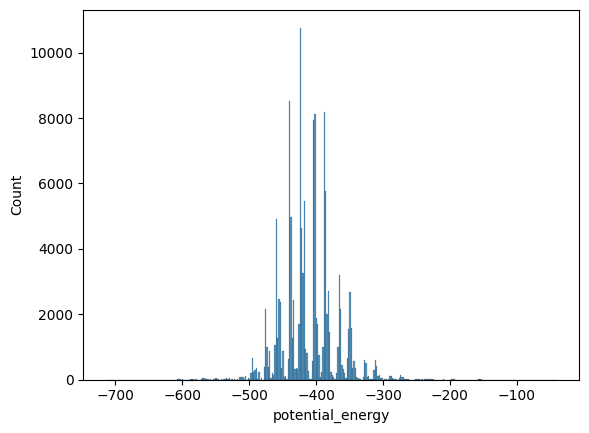

In [ ]:
# Energia potencial
potential = pd.read_csv('potential_energy.csv')
potential

sns.histplot(potential['potential_energy']);

In [ ]:
#  Contribuciones 
scalar = pd.read_csv('scalar_coupling_contributions.csv')
scalar

,molecule_name,atom_index_0,atom_index_1,type,fc,sd,pso,dso
0,dsgdb9nsd_000001,1,0,1JHC,83.022400,0.254579,1.258620,0.272010
1,dsgdb9nsd_000001,1,2,2JHH,-11.034700,0.352978,2.858390,-3.433600
2,dsgdb9nsd_000001,1,3,2JHH,-11.032500,0.352944,2.858520,-3.433870
3,dsgdb9nsd_000001,1,4,2JHH,-11.031900,0.352934,2.858550,-3.433930
4,dsgdb9nsd_000001,2,0,1JHC,83.022200,0.254585,1.258610,0.272013
...,...,...,...,...,...,...,...,...
4659071,dsgdb9nsd_133884,17,4,2JHC,3.586440,0.019741,0.150477,-0.213205
4659072,dsgdb9nsd_133884,17,5,3JHC,0.674583,-0.007276,0.305078,-0.403388
4659073,dsgdb9nsd_133884,17,6,3JHC,1.337470,-0.028423,0.312240,-0.447920
4659074,dsgdb9nsd_133884,17,7,2JHC,4.800620,0.139202,-0.053102,-0.124710


###De la grafica que se muestra en la parte de inferior podemos observar que gran parte de los valores para las coordenadas del momento dipolar tienen como valor cero.

###Por otro lado, el momento dipolar que nos entrega el DF las columnas de las coordenadas de un vector total resultado de la suma de todos los momentos dipolares de la molecula, por lo que, este vector resultante es quien apunta hacia la region mas negativa de la molecula, dado que, este va desde las cargas positivas hasta las cargas negativas.

###Tambien, al tener las coordenadas podemos  obtener el valor de la magnitud del momento dipolar.


###Por otro lado, se remplanzara con NaN los datos aleatoriamente con el fin de que se cumpla la condición de el 5%.

<Axes: xlabel='X', ylabel='Count'>

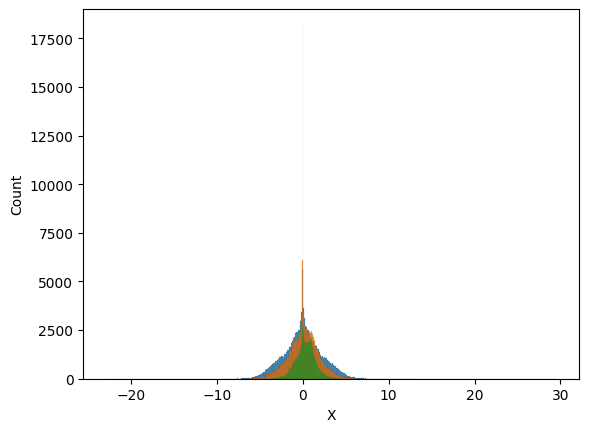

In [ ]:
#la funcion 'sns' nos permite graficar dF, y observar las densidad de los datos, es decir
#en que mayor proporcion se encuentran estos
sns.histplot(dipole['X'])
sns.histplot(dipole['Y'])
sns.histplot(dipole['Z'])

Unir las columnas de potential_energy.csv y de dipole_moments.csv 

In [ ]:

#Se realiza el cambio del nombre de las columnas del archivo dipole_moments.csv
# esto nos ayudar a dar claridad en los datos
dipole.columns=['molecule_name','DM_X','DM_Y','DM_Z']

#Se unen los datos de dipole_moments.csv y potential_energy.csv
dipole_and_potential = dipole.join(potential, rsuffix='other')
del dipole_and_potential['molecule_nameother']

dipole_and_potential

,molecule_name,DM_X,DM_Y,DM_Z,potential_energy
0,dsgdb9nsd_000001,0.0000,0.0000,0.0000,-40.523680
1,dsgdb9nsd_000002,-0.0002,0.0000,1.6256,-56.560246
2,dsgdb9nsd_000003,0.0000,0.0000,-1.8511,-76.426077
3,dsgdb9nsd_000004,0.0000,0.0000,0.0000,-77.335268
4,dsgdb9nsd_000005,0.0000,0.0000,-2.8937,-93.428488
...,...,...,...,...,...
130784,dsgdb9nsd_133881,1.2590,0.1153,-1.0814,-400.761274
130785,dsgdb9nsd_133882,-0.3710,-1.2435,0.0000,-400.757209
130786,dsgdb9nsd_133883,-0.4359,1.1694,-0.0000,-380.894376
130787,dsgdb9nsd_133884,1.3623,1.4058,-0.0000,-364.872596


Se unen los datos de la celda anterior con los de entrenamiento o test y luego con los de scalar

In [ ]:
def  Modificacion(df):
  df = df.set_index('molecule_name').join(dipole_and_potential.set_index('molecule_name'))
  df = df.set_index('id').join(scalar, rsuffix='other')
  del df['atom_index_0other']
  del df['atom_index_1other']
  del df['typeother']
  return df

In [ ]:
#Se realiza el cambio de variable categórica de 'tipo de molecula' a variable numérica y designación de nuevas columnas
new_cols = ['atom_index_0', 'atom_index_1', 'type_1JHC', 'type_1JHN', 'type_2JHC', 'type_2JHH', 'type_2JHN',
       'type_3JHC', 'type_3JHH', 'type_3JHN', 'DM_X', 'DM_Y', 'DM_Z','potential_energy', 'fc', 'sd', 'pso', 'dso']

def Limpieza(d):
  # llama a la funcion modificacion
  d = Modificacion(d)

  d['type'].replace(['1JHC', '1JHN', '2JHC', '2JHH','2JHN', '3JHC', '3JHH', '3JHN'],[0, 1, 2, 3, 4, 5, 6, 7], inplace=True)
  
  simple_array = d['type'].values

  encoded_array = np.zeros((simple_array.size, simple_array.max()+1), dtype=int)

  encoded_array[np.arange(simple_array.size),simple_array] = 1

  print(encoded_array.shape)


  k = pd.DataFrame(encoded_array, columns=['type_1JHC', 'type_1JHN', 'type_2JHC',
      'type_2JHH', 'type_2JHN', 'type_3JHC', 'type_3JHH', 'type_3JHN'], index=d.index)
  d = d.join(k)
  del d['type']
  d = d.reindex(columns=new_cols)
  return d
  

In [ ]:
data_train = Limpieza(df_train)
data_train

(4659076, 8)


,atom_index_0,atom_index_1,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,DM_X,DM_Y,DM_Z,potential_energy,fc,sd,pso,dso
id,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,0.0000,0.0000,0.0,-40.523680,83.022400,0.254579,1.258620,0.272010
1,1,2,0,0,0,1,0,0,0,0,0.0000,0.0000,0.0,-40.523680,-11.034700,0.352978,2.858390,-3.433600
2,1,3,0,0,0,1,0,0,0,0,0.0000,0.0000,0.0,-40.523680,-11.032500,0.352944,2.858520,-3.433870
3,1,4,0,0,0,1,0,0,0,0,0.0000,0.0000,0.0,-40.523680,-11.031900,0.352934,2.858550,-3.433930
4,2,0,1,0,0,0,0,0,0,0,0.0000,0.0000,0.0,-40.523680,83.022200,0.254585,1.258610,0.272013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659071,17,4,0,0,1,0,0,0,0,0,1.3623,1.4058,-0.0,-364.872596,3.586440,0.019741,0.150477,-0.213205
4659072,17,5,0,0,0,0,0,1,0,0,1.3623,1.4058,-0.0,-364.872596,0.674583,-0.007276,0.305078,-0.403388
4659073,17,6,0,0,0,0,0,1,0,0,1.3623,1.4058,-0.0,-364.872596,1.337470,-0.028423,0.312240,-0.447920


### Dado que el data set contiene  4.659.076 filas, se hará uso unicamente de 500.023 filas, puesto que el uso de un data set tan grande presenta inconvenientes a la hora de correr el codigo, ya que excede las capacidades de RAM y dificulta el procesamiento de los datos. Se optó por dicha cantidad especifica de filas con el objetivo de respetar la informacion completa correspondiente al indice atomico de la ultima molecula en la muestra tomanda.

In [ ]:
data_train=data_train[0:500023]

### Se busca conocer el valor maximo del indice atomico para posteriormente generar las columnas requeridas y hacer una separacion de la informacion en diferentes columnas para asi obtener mas de 30 columnas en el data set y asi cumplir con el requisito pedido para el proyecto. 

In [ ]:
print("Maximio indice atomico 0: "+str(data_train["atom_index_0"].max()))
print("Maximo indice atomico 1: "+str(data_train["atom_index_1"].max()))

Maximio indice atomico 0: 25
Maximo indice atomico 1: 25


### Se buscará separar el indice atomico 0 y 1 en columnas con el proposito de obtener mas de 30 columnas en el data set, de la celda anterior poder observar que la cantidad de columnas que se crearan por cada indice serán 25 por lo que se añadirá un total de 50 columnas al data set con la informacion de indice atomico. 

In [ ]:
i=0
j=0
for i in range(26):
  data_train["atom_index_0_"+str(i)]=0
for j in range(26):
  data_train["atom_index_1_"+str(j)]=0


In [ ]:
data_train

,atom_index_0,atom_index_1,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,...,atom_index_1_16,atom_index_1_17,atom_index_1_18,atom_index_1_19,atom_index_1_20,atom_index_1_21,atom_index_1_22,atom_index_1_23,atom_index_1_24,atom_index_1_25
id,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,3,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,4,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500018,13,2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
500019,13,3,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
500020,13,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for f in range(data_train.shape[0]):
    data_train["atom_index_0_"+str(data_train.iloc[f,0])][f]=1
    data_train["atom_index_1_"+str(data_train.iloc[f,1])][f]=1

In [ ]:
del data_train["atom_index_0"]
del data_train["atom_index_1"]

In [ ]:
data_train

,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,DM_X,DM_Y,...,atom_index_1_16,atom_index_1_17,atom_index_1_18,atom_index_1_19,atom_index_1_20,atom_index_1_21,atom_index_1_22,atom_index_1_23,atom_index_1_24,atom_index_1_25
id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500018,0,0,0,0,0,1,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0
500019,0,0,1,0,0,0,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0
500020,0,1,0,0,0,0,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0


### En caso de que se desee guardar y cargar posteriormente el data set creado con los parametros establecidos para no tener que correr nuevamente las lineas anteriores

In [ ]:

data_train.to_csv('/content/drive/MyDrive/data_train.csv',index=False)

In [ ]:
data_train=pd.read_csv('/content/drive/MyDrive/data_train.csv')

In [ ]:
data_train

,type_1JHC,type_1JHN,type_2JHC,type_2JHH,type_2JHN,type_3JHC,type_3JHH,type_3JHN,DM_X,DM_Y,...,atom_index_1_16,atom_index_1_17,atom_index_1_18,atom_index_1_19,atom_index_1_20,atom_index_1_21,atom_index_1_22,atom_index_1_23,atom_index_1_24,atom_index_1_25
0,1,0,0,0,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500018,0,0,0,0,0,1,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0
500019,0,0,1,0,0,0,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0
500020,0,1,0,0,0,0,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0
500021,0,0,1,0,0,0,0,0,2.5054,-2.9585,...,0,0,0,0,0,0,0,0,0,0


### Como se menciono anteriormente es necesario remplazar aleatoriamente los datos por NaN para cumplir con el requisito de al menos un 5% de datos faltantes en al menos 3 columnas.





In [ ]:
# de los datos totales por fila se tiene que el 5% esta dado por 25000
for i in range(25000):
  #crea un entero de forma random 
  ram = random.randint(0,500023)
  ram2 = random.randint(0,500023)
  ram3 = random.randint(0,500023)
  # hace el remplazo 
  data_train.iloc[ram, 8] = np.nan
  data_train.iloc[ram2, 9] = np.nan
  data_train.iloc[ram3, 10] = np.nan

In [ ]:
df_train=df_train[0:500023]

In [ ]:
#Se busca convertir los data_frame como una representacion de numpy (arrays)
np1 = data_train.values
np2 = df_train["scalar_coupling_constant"].values

#Se reemplazan los valores nan por el promedio de la columna
np1[:,8] = np.nan_to_num(np1[:,8], nan=np.nanmean(np1[:,8]))
np1[:,9] = np.nan_to_num(np1[:,9], nan=np.nanmean(np1[:,9]))
np1[:,10] = np.nan_to_num(np1[:,10], nan=np.nanmean(np1[:,10]))
     

In [ ]:
#De entrenamiento se saca un conjunto de datos que nos serviran para subentrenamiento y subtesteo
np1_train, np1_test, np2_train, np2_test = train_test_split(np1,np2, test_size=0.3)
print (np1_train.shape, np1_test.shape, np2_train.shape, np2_test.shape)

(350016, 68) (150007, 68) (350016,) (150007,)



### **Modelos**

#### Modelo de regresion lineal

In [ ]:
#Se plantea un modelo lineal y se comprueba que el score alcanzado por los datos sea superior a 0.9 
modelo_l = LinearRegression()
modelo_l.fit(np1_train, np2_train)

print("Score train: "+ str(modelo_l.score(np1_train, np2_train)))
print("Score test: "+ str(modelo_l.score(np1_test, np2_test)))

Score train: 0.999999999995069
Score test: 0.9999999999950023


## Se calculará el valor absoluto medio y error cuadratico medio para el modelo de regresion lineal 

In [ ]:
#Se calcula el valor absoluto medio y error cuadratico medio
print("Valor absoluto medio: " + str(median_absolute_error(np2_test, modelo_l.predict(np1_test))))
print("Error cuadratico medio: " + str(mean_squared_error(np2_test, modelo_l.predict(np1_test))))

Valor absoluto medio: 3.7828450556443016e-06
Error cuadratico medio: 6.397909724994961e-09


In [ ]:
def rel_mrae(estimator, X, y):
    preds = estimator.predict(X)
    return np.mean(np.abs(preds-y)/y)

In [ ]:
rel_mrae(modelo_l, np1_train, np2_train), rel_mrae(modelo_l, np1_test, np2_test)

(-5.618877491213306e-07, 7.485530804400576e-07)

In [ ]:
preds = modelo_l.predict(np1_test)
errors = np.abs(preds-np2_test)/np2_test

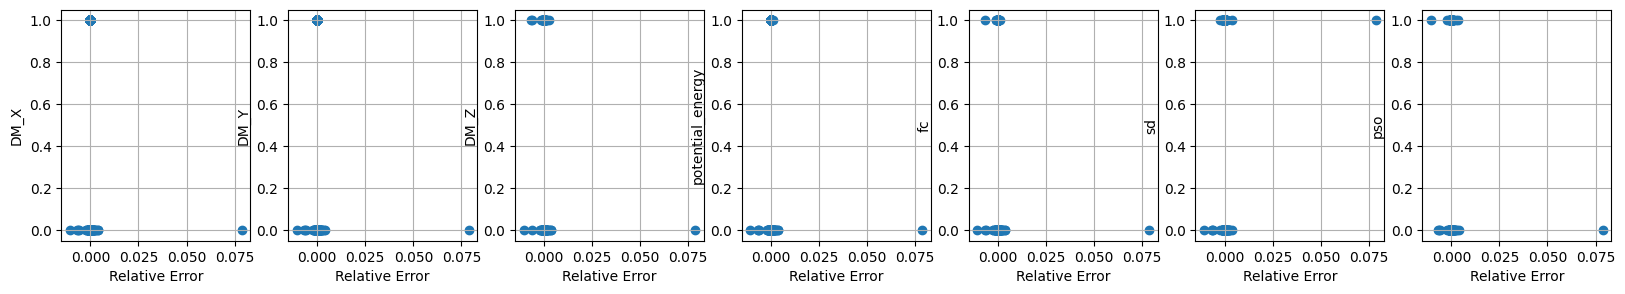

In [ ]:
plt.figure(figsize=(20,3))
cols = new_cols[10:-1]
for i,col in enumerate(cols):
    plt.subplot(1,len(cols),i+1)
    plt.scatter(errors, np1_test[:,i])
    plt.ylabel(col)
    plt.xlabel("Relative Error")
    plt.grid();

In [ ]:
corrcoefs = pd.DataFrame([np.corrcoef(np1_test[:,i], errors)[0,1] for i in range(len(cols))], index=cols, columns=["corrcoef"])
corrcoefs


,corrcoef
DM_X,0.000374
DM_Y,-0.000008
DM_Z,-0.004866
potential_energy,-0.004502
fc,-0.001601
sd,0.006690
pso,0.000383


In [ ]:
from progressbar import progressbar as pbar

def bootstrap_score(estimator, X, y, test_size):
  trscores, tsscores = [], []
  for _ in range(10):
    np1_train, np1_test, np2_train, np2_test = train_test_split(X,y, test_size=test_size)
    estimator.fit(np1_train, np2_train)
    trscores.append(rel_mrae(estimator, np1_train, np2_train))
    tsscores.append(rel_mrae(estimator, np1_test, np2_test))

  return (np.mean(trscores), np.std(trscores)), (np.mean(tsscores), np.std(tsscores))

In [ ]:
estimator = LinearRegression()
(trmean, trstd), (tsmean, tsstd) = bootstrap_score(estimator, np1, np2, test_size=0.3)
print ("Train score %.3f (±%.4f)"%(trmean, trstd))
print ("Test score  %.3f (±%.4f)"%(tsmean, tsstd))

Train score 0.000 (±0.0000)
Test score  -0.000 (±0.0000)


In [ ]:
from sklearn.model_selection import ShuffleSplit, KFold,cross_val_score
ss = ShuffleSplit(n_splits=3, test_size=0.3)

for a,b in ss.split(range(10)):
    print (a, b)

[1 4 2 7 3 8 5] [9 6 0]
[2 0 1 8 5 6 3] [9 7 4]
[4 2 8 7 3 0 9] [6 1 5]


In [ ]:
z = cross_val_score(modelo_l, np1, np2, cv = ShuffleSplit(n_splits=10, test_size=0.3), scoring=rel_mrae)
print (z)
print ("Test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[-1.20111549e-06 -1.80322935e-06  4.43061172e-07 -1.01956527e-06
  6.29108914e-07  9.82581005e-07  4.60874197e-07 -5.92276271e-07
  1.54275471e-07  3.91830880e-07]
Test score  -0.000 (±0.0000)


In [ ]:
ss = KFold(n_splits=3)

for a,b in ss.split(range(10)):
    print (a, b)

[4 5 6 7 8 9] [0 1 2 3]
[0 1 2 3 7 8 9] [4 5 6]
[0 1 2 3 4 5 6] [7 8 9]


In [ ]:
z = cross_val_score(modelo_l, np1, np2, cv = KFold(n_splits=10), scoring=rel_mrae)
print (z)
print ("Test score  %.3f (±%.4f)"%(np.mean(z), np.std(z)))

[ 3.55463010e-07  1.10061081e-06  8.52248385e-07 -5.92834560e-06
  2.35465188e-06  2.08904035e-07  1.80558355e-07 -9.42029790e-08
  9.37852844e-07  4.95866325e-07]
Test score  0.000 (±0.0000)


In [ ]:
from sklearn.model_selection import ShuffleSplit

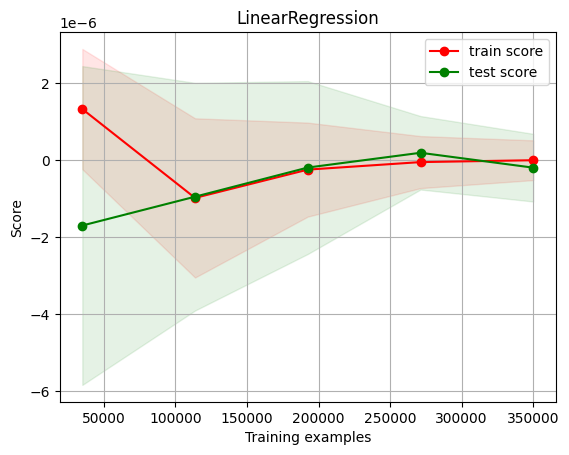

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=.3)

ch.plot_learning_curve(estimator, estimator.__class__.__name__, np1, np2, 
                       cv=cv, scoring=rel_mrae)

#### **Arbol de decisión**  

In [ ]:
dt = DecisionTreeRegressor(max_depth=2)
dt.fit(np1,np2)
y_preds = dt.predict(np1)
print('El Score obtenido: '+str (dt.score(np1,np2)))

NameError: ignored

In [ ]:
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(np1,np2)
y_preds = dt.predict(np1)
print('El Score obtenido: '+str (dt.score(np1,np2)))

In [ ]:
dt = DecisionTreeRegressor(max_depth=6)
dt.fit(np1,np2)
y_preds = dt.predict(np1)
print('El Score obtenido: '+str (dt.score(np1,np2)))

In [ ]:
dt = DecisionTreeRegressor(max_depth=8)
dt.fit(np1,np2)
y_preds = dt.predict(np1)
print('El Score obtenido: '+str (dt.score(np1,np2)))

In [ ]:
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(np1,np2)
y_preds = dt.predict(np1)
print('El Score obtenido: '+str (dt.score(np1,np2)))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
estimator = DecisionTreeRegressor(max_depth=8)
ch.plot_learning_curve(estimator, estimator.__class__.__name__, np1, np2, cv=cv, scoring=rel_mrae)
     

**Random Forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=2, max_depth=2)
rf.fit(np1,np2)
print (rf.score(np1,np2),rf.score(np1,np2))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=3, max_depth=4)
rf.fit(np1,np2)
print (rf.score(np1,np2),rf.score(np1,np2))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=4, max_depth=8)
rf.fit(np1,np2)
print (rf.score(np1,np2),rf.score(np1,np2))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=5, max_depth=10)
rf.fit(np1,np2)
print (rf.score(np1,np2),rf.score(np1,np2))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestRegressor(n_estimators=10, max_depth=10)
rf.fit(np1,np2)
print (rf.score(np1,np2),rf.score(np1,np2))

In [ ]:
from sklearn.model_selection import cross_validate, ShuffleSplit

In [ ]:
estimator1 = DecisionTreeRegressor(max_depth=5)
z1 = cross_validate(estimator1, np1, np2, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))

In [ ]:
def report_cv_score(z):
    print ("test score   %.3f (±%.4f) with %d splits"%(np.mean(z["test_score"]), np.std(z["test_score"]), len(z["test_score"])))
    print ("train score  %.3f (±%.4f) with %d splits"%(np.mean(z["train_score"]), np.std(z["train_score"]), len(z["train_score"])))
    
report_cv_score(z1)    
ch.plot_learning_curve(estimator1, estimator.__class__.__name__, np1, np2, cv=cv, scoring=rel_mrae)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
estimator2 = DecisionTreeRegressor(max_depth=10)
z2 = cross_validate(estimator2, np1, np2, return_train_score=True, return_estimator=True,
                    scoring=rel_mrae, cv=ShuffleSplit(n_splits=10, test_size=0.1))  
report_cv_score(z2)    
ch.plot_learning_curve(estimator2, estimator.__class__.__name__, np1, np2, cv=cv, scoring=rel_mrae)

###**Modelos no supervisados**

**Análisis de Componentes Principales - PCA**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
Xp = pca.fit_transform(np1)
Xp

array([[ 3.10977575e+02,  8.95124762e+01,  6.49929368e-02, ...,
         1.94409634e-01, -6.21032339e-02,  4.55436168e-02],
       [ 3.17764561e+02, -4.35513029e+00,  7.23376167e-02, ...,
         5.17464469e-01, -1.47589246e-01,  6.22526749e-01],
       [ 3.17764406e+02, -4.35282249e+00,  7.29989755e-02, ...,
         4.18765205e-01,  5.54485488e-01,  5.03855388e-02],
       ...,
       [-2.27633861e+01,  1.45986375e+01,  2.55797590e+00, ...,
         2.63529373e-01,  4.68314963e-01, -1.93197582e-01],
       [-2.04526104e+01, -1.73829271e+01,  2.55686156e+00, ...,
         1.30764571e-01,  3.80615738e-01, -2.40714938e-01],
       [-2.07200860e+01, -1.36946439e+01,  2.55580121e+00, ...,
         2.77980707e-02,  2.86076120e-01, -3.37200915e-01]])

In [ ]:
pca = PCA(n_components=8)
Xp = pca.fit_transform(np1)
Xp

array([[ 3.10977575e+02,  8.95124762e+01,  6.49928401e-02, ...,
        -3.59508840e-01,  7.49745330e-02,  2.21667609e-01],
       [ 3.17764561e+02, -4.35513029e+00,  7.23376834e-02, ...,
        -3.66786774e-01, -1.15353883e-01,  4.91054770e-01],
       [ 3.17764406e+02, -4.35282249e+00,  7.29990411e-02, ...,
        -3.66419481e-01, -4.08881897e-03,  3.98000709e-01],
       ...,
       [-2.27633861e+01,  1.45986375e+01,  2.55797593e+00, ...,
         2.98885055e-01,  8.91772047e-02,  2.14936931e-01],
       [-2.04526104e+01, -1.73829271e+01,  2.55686150e+00, ...,
         2.89978395e-01,  7.00205359e-01,  1.42692056e-01],
       [-2.07200860e+01, -1.36946439e+01,  2.55580119e+00, ...,
         3.02097517e-01, -6.81781370e-01,  4.86523692e-02]])

In [ ]:
pca = PCA(n_components=6)
Xp = pca.fit_transform(np1)
Xp

array([[ 3.10977575e+02,  8.95124762e+01,  6.49929251e-02,
         3.04167189e-01,  6.54036571e-01, -3.59511038e-01],
       [ 3.17764561e+02, -4.35513029e+00,  7.23376315e-02,
         3.46479300e-01,  3.33013994e+00, -3.66773738e-01],
       [ 3.17764406e+02, -4.35282249e+00,  7.29989935e-02,
         3.45215305e-01,  3.33963390e+00, -3.66408175e-01],
       ...,
       [-2.27633861e+01,  1.45986375e+01,  2.55797592e+00,
         2.95488640e+00,  3.10546087e-01,  2.98867236e-01],
       [-2.04526104e+01, -1.73829271e+01,  2.55686152e+00,
         2.93500709e+00, -5.26405781e-01,  2.89977438e-01],
       [-2.07200860e+01, -1.36946439e+01,  2.55580119e+00,
         2.92340631e+00, -1.08798937e+00,  3.02018275e-01]])

In [ ]:
pca = PCA(n_components=4)
Xp = pca.fit_transform(np1)
Xp

array([[ 3.10977575e+02,  8.95124762e+01,  6.49929251e-02,
         3.04167189e-01],
       [ 3.17764561e+02, -4.35513029e+00,  7.23376315e-02,
         3.46479299e-01],
       [ 3.17764406e+02, -4.35282249e+00,  7.29989935e-02,
         3.45215305e-01],
       ...,
       [-2.27633861e+01,  1.45986375e+01,  2.55797592e+00,
         2.95488640e+00],
       [-2.04526104e+01, -1.73829271e+01,  2.55686152e+00,
         2.93500709e+00],
       [-2.07200860e+01, -1.36946439e+01,  2.55580119e+00,
         2.92340631e+00]])

In [ ]:
pca = PCA(n_components=2)
Xp = pca.fit_transform(np1)

In [ ]:
from sklearn.model_selection import train_test_split

np1_train, np1_test, np2_train, np2_test = train_test_split(np1,np2,test_size=.3)
np1_train.shape, np1_test.shape, np2_train.shape, np2_test.shape

((350016, 68), (150007, 68), (350016,), (150007,))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(np1_train, np2_train)
dt.score(np1_train, np2_train), dt.score(np1_test, np2_test)

(1.0, 0.9999948146211042)

In [ ]:
cs = range(10,68)
dtr, dts = [], []
for n_components in cs:
    print (".", end="")
    pca = PCA(n_components=n_components)
    pca.fit(np1_train)

    Xt_tr = pca.transform(np1_train)
    Xt_ts = pca.transform(np1_test)

    dt.fit(Xt_tr,np2_train)
    ypreds_tr = dt.predict(Xt_tr)
    ypreds_ts = dt.predict(Xt_ts)
    ypreds_tr.shape, ypreds_ts.shape
    dtr.append(np.mean(np2_train==ypreds_tr))
    dts.append(np.mean(np2_test==ypreds_ts))

..........................................................

In [ ]:
len(dtr), len(dts)

(58, 58)

In [ ]:
best_cs = cs[np.argmax(dts)]
best_cs

10

####Clasificación en el nuevo espacio de representación

In [ ]:
pca = PCA(n_components=best_cs)
pca.fit(np1_train)

Xt_tr = pca.transform(np1_train)
Xt_ts = pca.transform(np1_test )
dt.fit(Xt_tr,np2_train)
ypreds_tr = dt.predict(Xt_tr)
ypreds_ts = dt.predict(Xt_ts)
ypreds_tr.shape, ypreds_ts.shape
np.mean(np2_train==ypreds_tr),np.mean(np2_test==ypreds_ts)

(0.9999742868897422, 0.0038264880972221295)



#### CLUSTERING: K-MEANS



In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN


In [ ]:
n_clusters = 2

km = KMeans(n_clusters=n_clusters)
km.fit(np1)
y = km.predict(np1)
y.shape

(500023,)

In [ ]:
pd.Series(np2).value_counts()

-11.47670    10
-11.55860     9
-11.57180     9
-11.71420     9
-11.17010     8
             ..
-6.21110      1
 86.57070     1
 38.67760     1
-0.76835      1
 4.07769      1
Length: 433783, dtype: int64

In [ ]:
km.cluster_centers_

array([[ 9.68366086e-01,  3.16339141e-02,  1.83464355e-14,
         7.35661532e-14, -1.74443793e-14, -1.09579013e-13,
        -1.44051437e-14,  1.60427227e-14, -1.58470200e-02,
         2.22020318e-02,  2.51036942e-01, -3.58335718e+02,
         9.17165674e+01,  1.92220640e-01,  4.64158890e-01,
         8.74036695e-01,  0.00000000e+00,  3.63468948e-05,
         9.69250527e-05,  2.18081369e-04,  3.63468948e-04,
         1.28425695e-03,  4.79779011e-03,  2.54307107e-02,
         1.07780659e-01,  1.21531900e-01,  1.20053793e-01,
         1.12820761e-01,  1.06145048e-01,  9.67190870e-02,
         8.36705517e-02,  6.97739223e-02,  5.26908818e-02,
         3.87942523e-02,  2.48612760e-02,  1.65862996e-02,
         7.82669801e-03,  5.51261237e-03,  1.61137900e-03,
         1.12675374e-03,  1.33271947e-04,  1.33271947e-04,
         2.60643582e-01,  8.86379607e-02,  1.26656813e-01,
         1.18563571e-01,  1.19254162e-01,  1.15171194e-01,
         1.02328624e-01,  6.86471686e-02,  2.42312632e-0

In [ ]:
def plot_clusters(X,y):
    n_clusters = len(np.unique(y))
    cmap = plt.cm.bwr if n_clusters==2 else plt.cm.plasma
    cmap((y*255./(n_clusters-1)).astype(int))
    for i in np.unique(y):
        col = cmap((i*255./(n_clusters-1)).astype(int))
        Xr = X[y==i]
        plt.scatter(Xr[:,0], Xr[:,1], color=col, label="cluster %d"%i, alpha=.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1],marker="x", lw=5, s=200, color="black")
    plt.legend()    
    plt.xlabel("anchura del trilobite")
    plt.ylabel("largo del trilobite");



plot_clusters(X,y)